In [6]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn

PyTorch test score: 8.798953782932211e-05


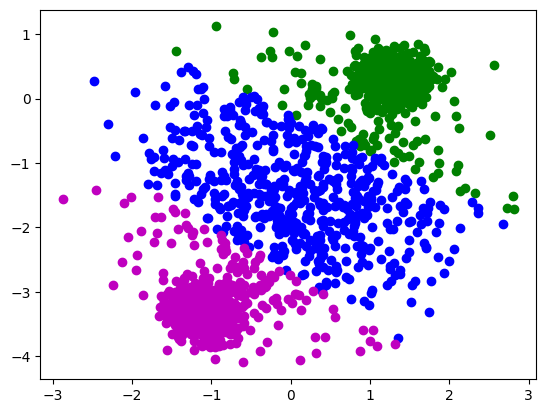

In [122]:
def load_data():
  X =np.load('data2D.npy')
  valid_batch = int(len(X) / 4.0)
  np.random.seed(45689)
  rnd_idx = np.arange(len(X))
  np.random.shuffle(rnd_idx)
  val_data = X[rnd_idx[:valid_batch]]
  train_data = X[rnd_idx[valid_batch:]]

  return train_data, val_data

def train_kmean_torch(train_data, k = 5, lr=0.1, epoch=150):
  #Define a cluster
  m = torch.rand((k, train_data.shape[1]), requires_grad=True)

  #Convert training data to a torch tensor
  X_train = torch.from_numpy(train_data)

  #TODO: define the Adam Optimizer
  optimizer = torch.optim.Adam([m], lr=lr)

  for epoch in range(epoch):
    list_mse = []
    for i in range(k):
      #TODO: fill in the append function
      #squared distance between each data points X[i] and every cluster mean m[j]
      dist_torch = torch.sum((X_train - m[i])**2, axis=1)
      list_mse.append(dist_torch)

    #TODO: calculate the loss function. Complete the
    #below 3 lines.
    list_mse_torch = torch.stack(list_mse)  #Stacks the list_mse[i]
    list_mse_torch_min,_ = torch.min(list_mse_torch, dim=0)  #Calculate the min
    L_train = torch.mean(list_mse_torch_min)  #Calculate the mean loss

    #Update the model using optimizer and L_train
    optimizer.zero_grad()
    L_train.backward()
    optimizer.step()

  L_train = L_train.detach().numpy()
  m = m.detach().numpy()

  return L_train, m

def evaluate(test_data, m):
  # TODO: complete this function.

  #Same as train_k_mean_torch functionality but with numpy including boradcasting

  dist_numpy = np.sum((test_data[:, np.newaxis, :] - m[np.newaxis, :, :]) ** 2, axis=2)

  # min square distance
  test_data_numpy_min = np.min(dist_numpy)

  # objective L(u) w.r.t the cluster means u for the test set
  L_test = np.mean(test_data_numpy_min)

  return L_test



def get_association(test_data, m):
  #This function returns the list of cluster associated for
  # each data points.
  num_cluster = len(m)
  N, d = test_data.shape
  L_k = np.zeros((N, num_cluster))

  for k in range(num_cluster):
    #TODO: calculate the distance per cluster
    #by fill in the blank
    L_k[:,k] = np.sum((test_data - m[k])**2, axis=1)

  #Assign to the nearest cluster.
  index = np.argmin(L_k, axis = -1)
  index = index.reshape(len(index), 1)
  return index

def test_pytorch(train_data, test_data, k=5):
  L,m = train_kmean_torch(train_data, k)
  index = get_association(test_data, m)
  new_X = np.concatenate((test_data, index), axis = 1)

  print ("PyTorch test score:", evaluate(test_data, m))
  color_list = ['g', 'b', 'm', 'y', 'c']

  for i in range(len(m)):
    tmp = new_X[new_X[...,-1] == i]
    plt.scatter(tmp[:,0], tmp[:,1], c=color_list[i])

def test_sckitlearn(train_data, test_data, k=5):
  #TODO: Create the KMeans object and fit the model using train_data
  # Use k cluster, 5000 maximum iterations and "auto" algorithm.
  # Fill in the line below.
  kmeans = KMeans(n_clusters=k, max_iter=5000, algorithm='lloyd').fit(train_data)

  #Association and visualization step
  index = kmeans.predict(test_data)
  index = index.reshape(len(index), 1)
  new_X = np.concatenate((test_data, index), axis = 1)

  color_list = ['g', 'b', 'm', 'y', 'c']
  print ("Scikit-learn test score:", evaluate(test_data, kmeans.cluster_centers_))
  for i in range(len(kmeans.cluster_centers_)):
    tmp = new_X[new_X[...,-1] == i]
    plt.scatter(tmp[:,0], tmp[:,1], c=color_list[i])

train_data, test_data = load_data()
test_pytorch(train_data, test_data, k=3)
#test_sckitlearn(train_data, test_data, k=5)